# N-Body Simulation Results Analysis

This notebook processes all CSV result files in the `results/` directory, aggregates the runtime data, and creates performance visualization plots.

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from pathlib import Path

# Set plot style
# plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [5]:
# Load all CSV files from the results directory
results_path = 'results/'
csv_files = glob.glob(f'{results_path}*.csv')
print(f"Found {len(csv_files)} CSV files in the results directory")

# Initialize a list to store dataframes
dfs = []

# Process each CSV file
for csv_file in csv_files:
    try:
        # Load CSV file
        df = pd.read_csv(csv_file)
        
        # Check if the required columns exist
        if all(col in df.columns for col in ['Method', 'Bodies', 'Dimension', 'Time(s)']):
            # Check for invalid values in the Time column
            df = df[pd.to_numeric(df['Time(s)'], errors='coerce').notna()]
            if not df.empty:
                dfs.append(df)
            else:
                print(f"Skipping {csv_file} - no valid time values")
        else:
            print(f"Skipping {csv_file} - required columns missing")
    except Exception as e:
        print(f"Error processing {csv_file}: {e}")

# Concatenate all dataframes
if dfs:
    all_results = pd.concat(dfs, ignore_index=True)
    print(f"Loaded {len(all_results)} rows of data")
    display(all_results.head())
else:
    print("No valid data found")
    all_results = pd.DataFrame()

Found 50 CSV files in the results directory
Skipping results/run_05072025_040830_N_5000000_2D.csv - no valid time values
Skipping results/run_05072025_045410_N_1000000_3D.csv - no valid time values
Skipping results/aggregated_results.csv - required columns missing
Loaded 563 rows of data
Skipping results/run_05072025_040830_N_5000000_2D.csv - no valid time values
Skipping results/run_05072025_045410_N_1000000_3D.csv - no valid time values
Skipping results/aggregated_results.csv - required columns missing
Loaded 563 rows of data


,Method,Bodies,Dimension,Time(s)
0,BruteForce_Sequential,10000,2,0.164108
1,BruteForce_OpenMP1,10000,2,0.046100
2,BruteForce_OpenMP2,10000,2,0.074726
3,BruteForce_Parlay1,10000,2,0.047027
4,BruteForce_Parlay2,10000,2,0.064119


In [6]:
# Group data by Bodies, Method, and Dimension and calculate average runtime
if not all_results.empty:
    # Convert columns to appropriate types
    all_results['Bodies'] = pd.to_numeric(all_results['Bodies'])
    all_results['Dimension'] = pd.to_numeric(all_results['Dimension'])
    all_results['Time(s)'] = pd.to_numeric(all_results['Time(s)'])
    
    # Group and compute average
    avg_results = all_results.groupby(['Bodies', 'Method', 'Dimension'])['Time(s)'].mean().reset_index()
    
    # Rename column for clarity
    avg_results.rename(columns={'Time(s)': 'Average Runtime (s)'}, inplace=True)
    
    print(f"Grouped data into {len(avg_results)} unique combinations")
    display(avg_results.head())
else:
    avg_results = pd.DataFrame()

Grouped data into 225 unique combinations


,Bodies,Method,Dimension,Average Runtime (s)
0,1000,BVH_OpenMP,2,0.004246
1,1000,BVH_OpenMP,3,0.006480
2,1000,BVH_Parlay,2,0.005208
3,1000,BVH_Parlay,3,0.005033
4,1000,BVH_Sequential,2,0.010395


In [7]:
# Add BruteForce_CUDA data manually
cuda_bodies = [1000, 10000, 100000, 200000, 500000, 1000000, 2000000, 5000000]
cuda_times = [0.000448512, 0.00565258, 0.0993744, 0.361864, 2.19412, 8.64006, 34.4182, 219.31]

# Create DataFrame for CUDA data
cuda_data = pd.DataFrame({
    'Bodies': cuda_bodies,
    'Method': ['BruteForce_CUDA'] * len(cuda_bodies),
    'Dimension': [2] * len(cuda_bodies),  # Adding for 2D as specified
    'Average Runtime (s)': cuda_times
})

# Append to the existing results
if not avg_results.empty:
    avg_results = pd.concat([avg_results, cuda_data], ignore_index=True)
    print(f"Added {len(cuda_bodies)} rows of BruteForce_CUDA data")
    display(cuda_data)

Added 8 rows of BruteForce_CUDA data


,Bodies,Method,Dimension,Average Runtime (s)
0,1000,BruteForce_CUDA,2,0.000449
1,10000,BruteForce_CUDA,2,0.005653
2,100000,BruteForce_CUDA,2,0.099374
3,200000,BruteForce_CUDA,2,0.361864
4,500000,BruteForce_CUDA,2,2.194120
5,1000000,BruteForce_CUDA,2,8.640060
6,2000000,BruteForce_CUDA,2,34.418200
7,5000000,BruteForce_CUDA,2,219.310000


In [8]:
# Save the aggregated data to a CSV file
if not avg_results.empty:
    output_file = 'results/aggregated_results.csv'
    avg_results.to_csv(output_file, index=False)
    print(f"Saved aggregated results to {output_file}")

Saved aggregated results to results/aggregated_results.csv


## Plotting Options

Select the y-axis scale for the performance plots:

In [9]:
# Set to 'log' for logarithmic or 'linear' for regular scale on y-axis
y_scale = 'linear'  # Options: 'log', 'linear'

print(f"Selected y-axis scale: {y_scale}")

Selected y-axis scale: linear


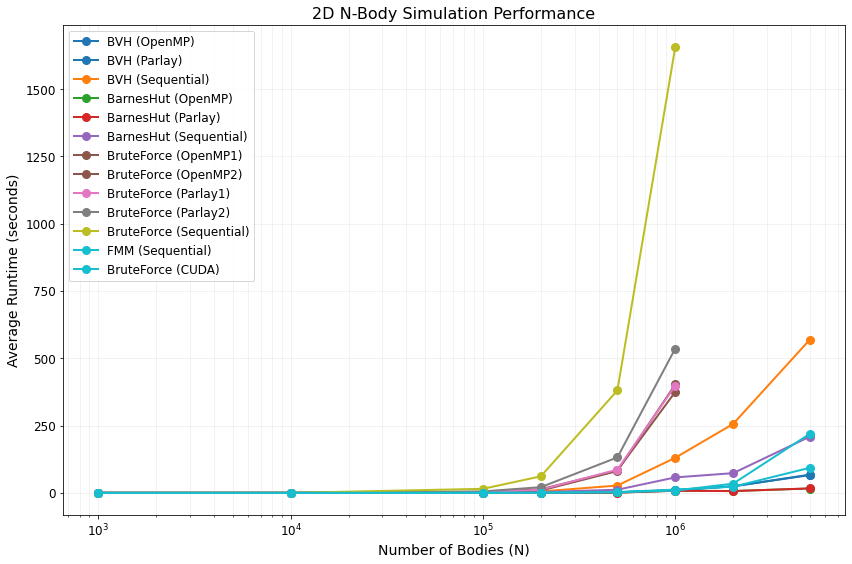

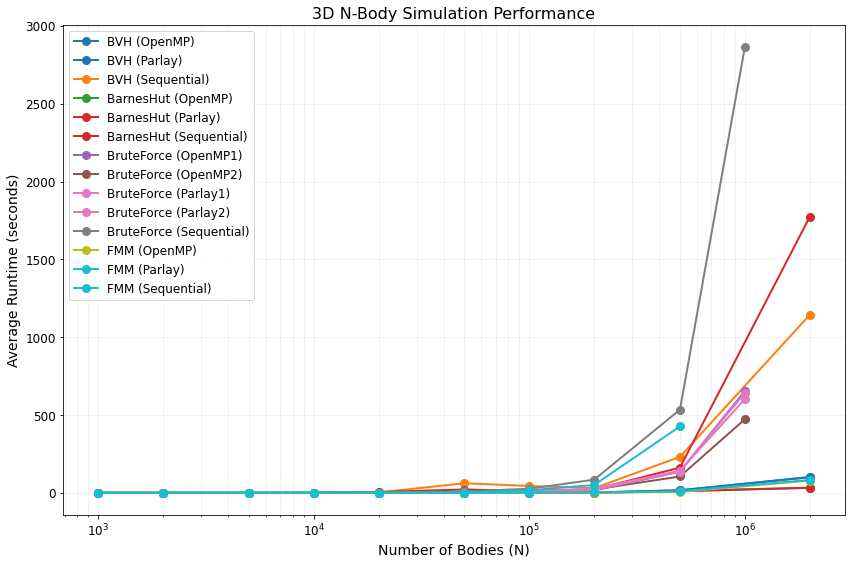

In [10]:
# Load the aggregated data and create plots with configurable y-scale
try:
    # Load the aggregated data
    agg_results = pd.read_csv('results/aggregated_results.csv')
    
    # Format method names for the legend
    def format_method_name(method):
        parts = method.split('_')
        if len(parts) >= 2:
            return f"{parts[0]} ({parts[1]})"
        return method
    
    # Create a new column with formatted method names
    agg_results['Method_Formatted'] = agg_results['Method'].apply(format_method_name)
    
    # Get unique dimensions
    dimensions = agg_results['Dimension'].unique()
    
    # Create a plot for each dimension
    for dim in dimensions:
        # Filter data for the current dimension
        dim_data = agg_results[agg_results['Dimension'] == dim]
        
        # Create figure
        plt.figure(figsize=(12, 8))
        
        # Get unique methods for color mapping
        methods = dim_data['Method_Formatted'].unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
        color_map = dict(zip(methods, colors))
        
        # Plot each method with the selected scale for y-axis
        for method in methods:
            method_data = dim_data[dim_data['Method_Formatted'] == method]
            
            # Use loglog for both axes logarithmic, or semilogx for only x logarithmic
            if y_scale == 'log':
                plt.loglog(method_data['Bodies'], method_data['Average Runtime (s)'], 'o-', 
                          label=method, linewidth=2, markersize=8, 
                          color=color_map[method])
            else:
                plt.semilogx(method_data['Bodies'], method_data['Average Runtime (s)'], 'o-', 
                           label=method, linewidth=2, markersize=8, 
                           color=color_map[method])
        
        # Add labels and title
        plt.xlabel('Number of Bodies (N)', fontsize=14)
        plt.ylabel('Average Runtime (seconds)', fontsize=14)
        plt.title(f'{int(dim)}D N-Body Simulation Performance', fontsize=16)
        plt.grid(True, which="both", ls="-", alpha=0.2)
        plt.legend(fontsize=12, frameon=True, fancybox=True, framealpha=0.8)
        
        # Add reference complexity line if using log scale
        if y_scale == 'log':
            x_range = np.logspace(np.log10(dim_data['Bodies'].min()), 
                                 np.log10(dim_data['Bodies'].max()), 100)
            
            # O(n log n) reference line (scaled to fit in the plot)
            if len(dim_data) > 0:
                # Find a reasonable scaling factor
                mid_n = np.median(dim_data['Bodies'])
                mid_t = np.median(dim_data['Average Runtime (s)'])
                scale_nlogn = mid_t / (mid_n * np.log(mid_n))
                
                # Plot reference lines
                plt.loglog(x_range, scale_nlogn * x_range * np.log(x_range), 'k--', alpha=0.5, 
                          linewidth=1.5, label='O(n log n)')
        
        plt.tight_layout()
        plt.savefig(f'results/performance_plot_{int(dim)}D_{y_scale}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
except Exception as e:
    print(f"Error creating plots: {e}")

## Speedup Analysis

Calculate speedup factors relative to the brute force sequential implementation:


No BruteForce_Sequential data for Bodies=2000000, Dimension=2
No BruteForce_Sequential data for Bodies=2000000, Dimension=3
No BruteForce_Sequential data for Bodies=5000000, Dimension=2

## Speedup Analysis for 2D


Bodies,1000,10000,100000,200000,500000,1000000
Method_Formatted,,,,,,
BarnesHut (Parlay),1.55,14.54,130.11,234.12,390.54,204.67
BarnesHut (OpenMP),0.95,14.13,116.78,201.73,343.28,205.97
BruteForce (CUDA),7.96,33.15,152.35,170.17,173.43,191.69
BVH (Parlay),0.69,10.89,59.11,122.16,168.83,170.46
BVH (OpenMP),0.84,8.56,51.57,113.27,151.97,158.37
FMM (Sequential),0.64,3.37,27.28,52.56,120.77,135.18
BarnesHut (Sequential),0.58,2.05,12.75,19.32,32.23,28.77
BVH (Sequential),0.34,1.53,5.40,11.49,13.92,12.69
BruteForce (OpenMP1),0.27,3.95,6.86,7.05,4.68,4.11


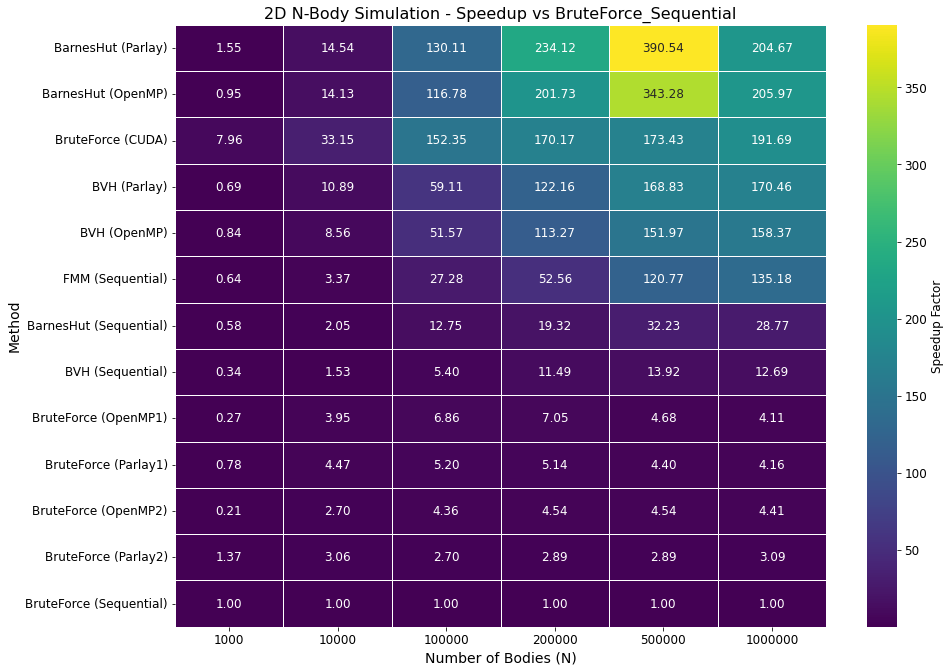


## Speedup Analysis for 3D


Bodies,1000,2000,5000,10000,20000,50000,100000,200000,500000,1000000
Method_Formatted,,,,,,,,,,
FMM (OpenMP),0.08,0.32,1.52,2.10,10.55,41.05,65.49,84.10,82.31,NaN
BarnesHut (Parlay),1.86,2.96,5.74,6.50,12.03,25.59,36.77,61.86,51.45,NaN
BarnesHut (OpenMP),0.94,3.27,12.11,5.62,10.52,17.89,33.89,54.52,38.89,NaN
FMM (Sequential),1.30,1.35,1.24,3.12,5.96,15.99,14.48,31.95,51.68,NaN
BVH (Parlay),1.35,1.99,3.90,3.92,9.29,14.55,16.16,33.83,33.94,NaN
BVH (OpenMP),1.05,3.13,3.51,3.07,7.11,12.25,14.47,32.52,30.89,NaN
BruteForce (Parlay1),0.90,1.89,4.26,3.56,4.99,6.61,6.09,4.68,3.90,4.46
BruteForce (OpenMP1),0.28,0.81,3.68,3.32,5.30,6.92,6.67,5.56,3.89,4.38
BruteForce (OpenMP2),0.27,0.84,3.78,2.43,3.59,5.04,4.56,3.85,5.07,6.06


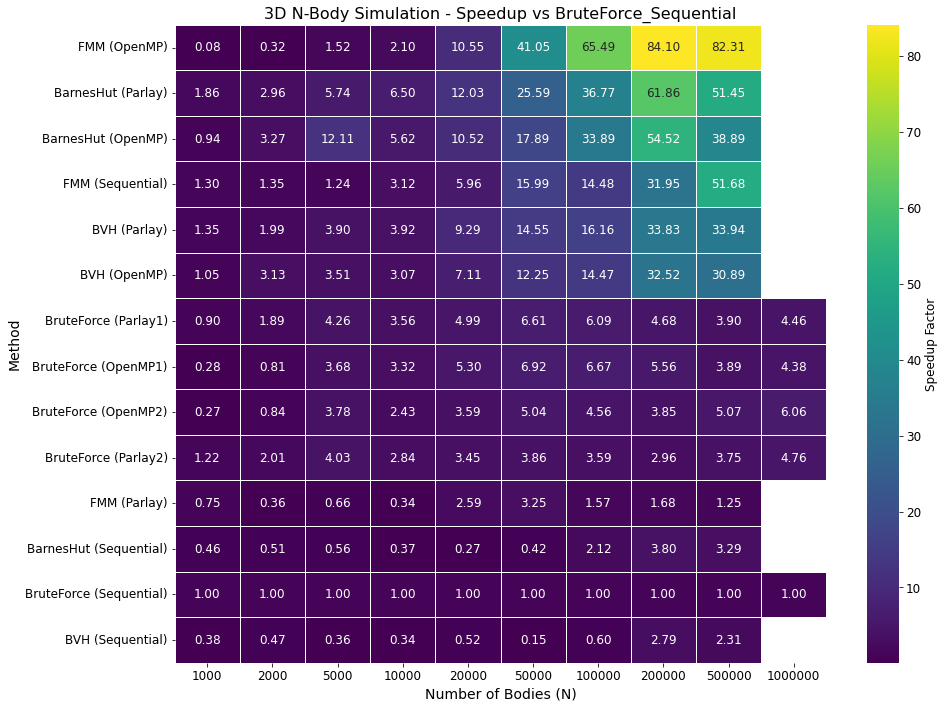

In [11]:
# Calculate speedup factors relative to BruteForce_Sequential
try:
    # Ensure we have the aggregated data
    if 'agg_results' not in locals() or agg_results.empty:
        agg_results = pd.read_csv('results/aggregated_results.csv')
        agg_results['Method_Formatted'] = agg_results['Method'].apply(format_method_name)
    
    # Create a pivot table with speedup factors
    speedup_data = []
    
    # Process each combination of Bodies and Dimension
    for (body_count, dim), group in agg_results.groupby(['Bodies', 'Dimension']):
        # Find the BruteForce_Sequential runtime for this configuration
        bf_sequential = group[group['Method'] == 'BruteForce_Sequential']
        
        # Skip if we don't have BruteForce_Sequential data for this configuration
        if bf_sequential.empty:
            print(f"No BruteForce_Sequential data for Bodies={body_count}, Dimension={dim}")
            continue
        
        # Get the reference runtime
        ref_runtime = bf_sequential['Average Runtime (s)'].values[0]
        
        # Calculate speedup for each method
        for _, row in group.iterrows():
            speedup = ref_runtime / row['Average Runtime (s)']
            
            # Add to results
            speedup_data.append({
                'Bodies': body_count,
                'Dimension': dim,
                'Method': row['Method'],
                'Method_Formatted': row['Method_Formatted'],
                'Runtime (s)': row['Average Runtime (s)'],
                'Speedup vs BruteForce': speedup
            })
    
    # Create DataFrame from results
    speedup_df = pd.DataFrame(speedup_data)
    
    # Display summary for each dimension
    for dim in speedup_df['Dimension'].unique():
        print(f"\n## Speedup Analysis for {int(dim)}D")
        
        # Create pivot table for this dimension
        dim_speedup = speedup_df[speedup_df['Dimension'] == dim].pivot_table(
            index='Method_Formatted', 
            columns='Bodies',
            values='Speedup vs BruteForce',
            aggfunc='mean'
        )
        
        # Sort methods by their average speedup (descending)
        avg_speedups = dim_speedup.mean(axis=1).sort_values(ascending=False)
        dim_speedup = dim_speedup.reindex(avg_speedups.index)
        
        # Round to 2 decimal places for display
        display(dim_speedup.round(2))
        
        # Create a heatmap visualization
        plt.figure(figsize=(14, len(dim_speedup) * 0.5 + 3))
        ax = sns.heatmap(dim_speedup, annot=True, fmt='.2f', cmap='viridis', 
                   linewidths=0.5, cbar_kws={'label': 'Speedup Factor'})
        plt.title(f"{int(dim)}D N-Body Simulation - Speedup vs BruteForce_Sequential", fontsize=16)
        plt.xlabel('Number of Bodies (N)', fontsize=14)
        plt.ylabel('Method', fontsize=14)
        plt.tight_layout()
        plt.savefig(f'results/speedup_heatmap_{int(dim)}D.png', dpi=300, bbox_inches='tight')
        plt.show()
        
except Exception as e:
    print(f"Error calculating speedup: {e}")

## 3D vs 2D Performance Comparison

This analysis calculates the ratio of 3D to 2D runtimes for each method across different body counts to quantify the overhead of adding an extra dimension.

Found 12 methods with both 2D and 3D implementations

Overall average 3D/2D runtime ratio: 4.03

Average 3D/2D ratio by method:
  BruteForce (Parlay2): 1.42
  BruteForce (OpenMP2): 1.48
  BruteForce (Sequential): 1.59
  BruteForce (Parlay1): 1.60
  BruteForce (OpenMP1): 1.72
  FMM (Sequential): 2.49
  BVH (Parlay): 4.56
  BVH (OpenMP): 4.59
  BarnesHut (Parlay): 5.30
  BarnesHut (OpenMP): 5.61
  BVH (Sequential): 7.07
  BarnesHut (Sequential): 10.93

Detailed 3D/2D ratios by method and body count:


Bodies,1000,10000,100000,200000,500000,1000000,2000000
Method_Formatted,,,,,,,
BruteForce (Parlay2),2.14,1.48,1.33,1.35,1.08,1.12,NaN
BruteForce (OpenMP2),1.48,1.53,1.69,1.63,1.26,1.26,NaN
BruteForce (Sequential),1.90,1.38,1.77,1.38,1.40,1.73,NaN
BruteForce (Parlay1),1.65,1.72,1.51,1.52,1.59,1.61,NaN
BruteForce (OpenMP1),1.81,1.64,1.82,1.75,1.69,1.62,NaN
FMM (Sequential),0.93,1.49,3.33,2.27,3.28,NaN,3.64
BVH (Parlay),0.97,3.83,6.48,4.99,6.99,NaN,4.14
BVH (OpenMP),1.53,3.83,6.31,4.81,6.91,NaN,4.12
BarnesHut (Parlay),1.59,3.08,6.26,5.23,10.66,NaN,4.95


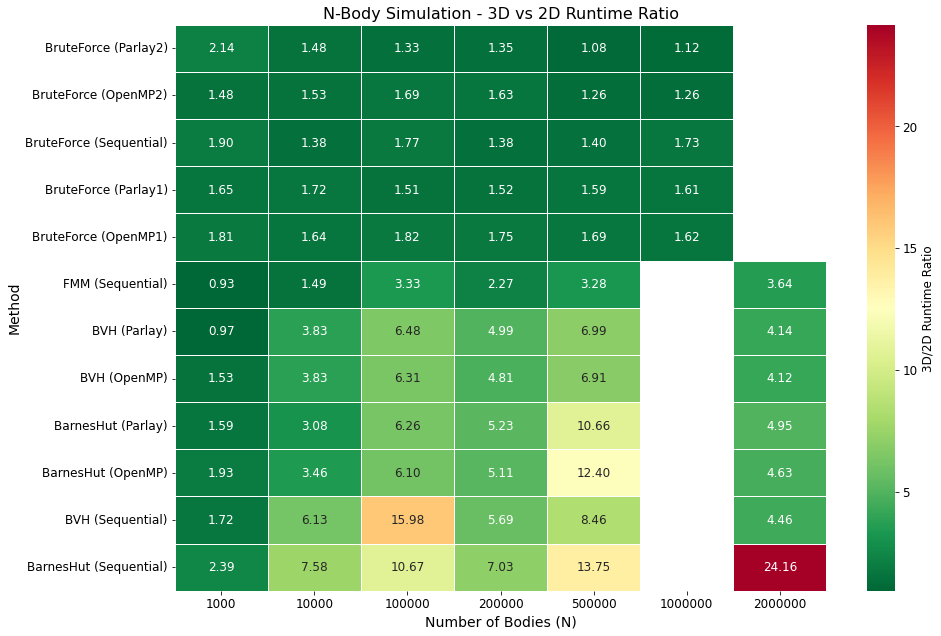

In [12]:
# Analyze 3D vs 2D performance ratio
try:
    # Ensure we have the aggregated data
    if 'agg_results' not in locals() or agg_results.empty:
        agg_results = pd.read_csv('results/aggregated_results.csv')
        if 'Method_Formatted' not in agg_results.columns:
            agg_results['Method_Formatted'] = agg_results['Method'].apply(format_method_name)
    
    # Get methods that have both 2D and 3D implementations
    methods_2d = set(agg_results[agg_results['Dimension'] == 2]['Method'])
    methods_3d = set(agg_results[agg_results['Dimension'] == 3]['Method'])
    common_methods = methods_2d.intersection(methods_3d)
    
    if not common_methods:
        print("No methods with both 2D and 3D implementations found.")
    else:
        print(f"Found {len(common_methods)} methods with both 2D and 3D implementations")
        
        # Create a DataFrame to store 3D/2D ratios
        ratio_data = []
        
        # Process each method
        for method in common_methods:
            method_data = agg_results[agg_results['Method'] == method]
            
            # Get data for 2D and 3D
            data_2d = method_data[method_data['Dimension'] == 2].set_index('Bodies')
            data_3d = method_data[method_data['Dimension'] == 3].set_index('Bodies')
            
            # Find common body counts
            common_bodies = set(data_2d.index).intersection(set(data_3d.index))
            
            for body_count in common_bodies:
                runtime_2d = data_2d.loc[body_count, 'Average Runtime (s)']
                runtime_3d = data_3d.loc[body_count, 'Average Runtime (s)']
                ratio = runtime_3d / runtime_2d
                
                ratio_data.append({
                    'Method': method,
                    'Method_Formatted': agg_results[agg_results['Method'] == method]['Method_Formatted'].iloc[0],
                    'Bodies': body_count,
                    '3D/2D Ratio': ratio
                })
        
        # Create DataFrame from collected data
        ratio_df = pd.DataFrame(ratio_data)
        
        # Create pivot table for heatmap
        ratio_pivot = ratio_df.pivot_table(
            index='Method_Formatted',
            columns='Bodies',
            values='3D/2D Ratio',
            aggfunc='mean'
        )
        
        # Sort methods by average ratio
        avg_ratios = ratio_pivot.mean(axis=1).sort_values()
        ratio_pivot = ratio_pivot.reindex(avg_ratios.index)
        
        # Calculate overall average ratio
        overall_avg = ratio_df['3D/2D Ratio'].mean()
        
        # Calculate method averages
        method_avgs = ratio_df.groupby('Method_Formatted')['3D/2D Ratio'].mean().sort_values()
        
        # Display the results
        print(f"\nOverall average 3D/2D runtime ratio: {overall_avg:.2f}")
        print("\nAverage 3D/2D ratio by method:")
        for method, ratio in method_avgs.items():
            print(f"  {method}: {ratio:.2f}")
        
        # Display the pivot table
        print("\nDetailed 3D/2D ratios by method and body count:")
        display(ratio_pivot.round(2))
        
        # Create heatmap visualization
        plt.figure(figsize=(14, len(ratio_pivot) * 0.5 + 3))
        sns.heatmap(ratio_pivot, annot=True, fmt='.2f', cmap='RdYlGn_r', 
                   linewidths=0.5, cbar_kws={'label': '3D/2D Runtime Ratio'})
        plt.title(f"N-Body Simulation - 3D vs 2D Runtime Ratio", fontsize=16)
        plt.xlabel('Number of Bodies (N)', fontsize=14)
        plt.ylabel('Method', fontsize=14)
        plt.tight_layout()
        plt.savefig('results/3D_vs_2D_ratio_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
        
except Exception as e:
    print(f"Error calculating 3D/2D ratios: {e}")
    import traceback
    traceback.print_exc()